In [1]:
import os
from pathlib import PureWindowsPath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import random
# import googletrans as translator
from pandas.tseries.offsets import *
import calendar   

In [2]:
data_dir = working_dir = PureWindowsPath(os.getcwd())
data_result_name = 'result.csv'

In [3]:
pd.set_option('display.max_columns', 30)

 Class utilities
- translation 
- outliers
- words dictionnary

In [4]:
class utilities:
    #-------------------------------------------------------------------------
    # retourne la liste des noms de colonne d'un type 
    #-------------------------------------------------------------------------
    def select_columns(df, type):
        columns = df.dtypes[df.dtypes.apply(lambda x : x == type)].index.tolist()
        return columns

    #-------------------------------------------------------------------------
    # identifier et gérer les valeurs extrêmes 
    # on considère le seuil de 1% pour déterminer les valeurs extrêmes; ce seuil
    # determine (sous l'hypothèse de normalité de la distribution) toutes les valeurs 
    # x | x > abs(mean - 3 * std) 
    #-------------------------------------------------------------------------
    def remove_outliers(df, col_name):

        def reject(ser : pd.Series):
            mean = ser.mean() 
            std  = 3 * ser.std()
  
            def f(x):
                reject = False

                if np.abs(x - mean) > std : 
                    reject = True
                return reject
    
            return f

        ser_col = df.loc[:,col_name]
        f_reject = reject(ser_col)
        df = df.loc[~ser_col.apply(f_reject)]

        return df

    #-------------------------------------------------------------------------
    # translate a word (one at a time) in english with googletrans
    #-------------------------------------------------------------------------
    def translate_word():

        trans = translator.Translator()

        def f(x : str):
            try :
                if not x.isalpha():
                    return x

                elif x == "SEL":
                    return "SALT"

                else :
                    # t = trans.translate(x)
                    # return t.text

                    return x

            except ValueError:
                print ("erreur dans la traduction", x)
        
        return f

    #-------------------------------------------------------------------------
    # fill a dictionnary with all word and count occurences
    # dict_words : dictionnary filled
    #-------------------------------------------------------------------------
    def build_word_dictionary(dict_words):
        assert type(dict_words) is dict
   
        def f(x : str):
            try :
                ser_words = pd.read_json(x, typ="records")
                for item in ser_words.iteritems():
                    word = item[1].upper()

                    if (dict_words.get(word) is not None) :
                        dict_words[word] += 1
                    else :
                        dict_words[word] = 1
        
            except Exception:   
                print ("build dictionary error")

        return f 

saves / loads a df to / from database

In [5]:
def helper_store_df_to_db(df, db_name, table_name) :

    db_file = PureWindowsPath(data_dir.joinpath(db_name + ".db" ))
    db = sqlite3.connect(db_file.as_posix())

    df.to_sql(table_name, db, chunksize=2000, if_exists='replace')
    db.close()

def helper_load_df_from_db(db_name, table_name) :

    db_file = PureWindowsPath(data_dir.joinpath(db_name + ".db"))
    db = sqlite3.connect(db_file.as_posix())

    df = pd.read_sql_query("select * from " + table_name, con=db)
    db.close()

    return df

def helper_store_csv_to_db(data_file, db_name, table_name) :
 
    db_file = PureWindowsPath(data_dir.joinpath(db_name + ".db" ))
    db = sqlite3.connect(db_file.as_posix())
    
    for chunk in pd.read_csv(data_file, chunksize=2000):
        chunk.to_sql(name=table_name, con=db, if_exists="append", index=False)  

    db.close()

 ETUDE A : analyse meta-data and clean-up

original file "en.openfoodfacts.org.products.tsv" est chargé dans une base 
will be loaded and stored in a database name 'food.db' table name  'data' 

In [6]:
def read_raw_data():

    data_file = PureWindowsPath(data_dir.joinpath('en.openfoodfacts.org.products.tsv'))
    helper_store_csv_to_db(data_file, "food", "data")

répertoire de travail

export to csv file all the columns containing null values

In [7]:
def export_null_columns(df, data_file) : 
   
    ser_column_null = df.isnull().sum()
    ser_column_null.sort_index(inplace=True)
    ser_column_null.to_csv(data_file)

analyze columns 

apply series of threshes (by step 10000) on the df and mesures the number
of remaining columns

plot the result  

In [8]:
def analyze_columns(df_food_study) :

    df = df_food_study.copy()
    
    null_values_max = df.isnull().sum().max()
    if null_values_max > 0:
        threshes = np.arange(0, null_values_max, 10000)
     
        rows = []

        def select_columns(df, thresh):
            df = df.dropna(thresh=thresh, axis=1)
        
            dict = {'_thresh' : 0, '_schape' : 0}
            dict['_thresh'] = thresh
            dict['_schape'] = df.shape[1]
    
            rows.append(dict)
        
        for thresh in threshes :
            select_columns (df, thresh)
    
        # build a dataframe based on dict of rows
        df_result = pd.DataFrame(rows)  
        df_result.set_index('_schape', inplace=True)
    
        df_result.to_csv(data_dir.joinpath(data_result_name))

        df_result.plot(figsize=(16,12), title="numbers of remaining columns in terms of 'threshes' for a df of shape (" +  
                                               str(df_food_study.shape[0]) + "," + str(df_food_study.shape[1]) + ")")
        plt.xlabel('numbers of remaining columns')
        plt.ylabel('thresh')

        plt.show()

First step of data cleaning
Columns will be reduced to a level that minimize the lost of relevant 
data 

resulting df will be store in database 

In [9]:
df_food = helper_load_df_from_db("food", "data")

In [10]:
# eliminate all columns with all null values
# df will be reduced from 163 columns to 147

df_food.dropna(axis=1, how="all", inplace=True)

In [11]:
# check for duplicated 

if df_food.drop_duplicates().shape == df_food.shape:
    print ("df doesn't contain duplicated data")

df doesn't contain duplicated data


In [ ]:
analyze_columns(df_food)

In [12]:
# a thesh level of 150'000 (all columns wiht number of null values > 150'000), defines a selection of 36 columns (which encompass 
# all the necessary columns for the next investigations

df_food_cl = df_food.dropna(thresh=150000, axis=1)    

In [13]:
df_food_cl.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,brands,brands_tags,countries,countries_tags,countries_en,ingredients_text,serving_size,...,nutrition_grade_fr,states,states_tags,states_en,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,3087.0,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,Ferme t'y R'nao,ferme-t-y-r-nao,en:FR,en:france,France,None,None,...,None,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530.0,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),None,None,US,en:united-states,United States,"Bananas, vegetable oil (coconut oil, corn oil ...",28 g (1 ONZ),...,d,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",2243.0,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,0.000,14.0,14.0
2,4559.0,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,Torn & Glasser,torn-glasser,US,en:united-states,United States,"Peanuts, wheat flour, sugar, rice flour, tapio...",28 g (0.25 cup),...,b,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",1941.0,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,0.250,0.0,0.0
3,16087.0,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,Grizzlies,grizzlies,US,en:united-states,United States,"Organic hazelnuts, organic cashews, organic wa...",28 g (0.25 cup),...,d,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",2540.0,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,0.482,12.0,12.0
4,16094.0,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,Bob's Red Mill,bob-s-red-mill,US,en:united-states,United States,Organic polenta,35 g (0.25 cup),...,None,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",1552.0,1.43,NaN,77.14,NaN,5.7,8.57,NaN,NaN,NaN,NaN


In [14]:
# eliminates columns containing word 'completed' which seems not to be relevant
# example : counting  occurrences  for column 'tags' 

df_food_cl.states_tags.where(lambda x : x.str.contains("completed")).count()

355975

In [15]:
# eliminates columns whose name contains 'states' or 'tags

df_food_cl = df_food_cl.drop([col for col in df_food_cl.columns if "states" in col], axis=1)
df_food_cl = df_food_cl.drop([col for col in df_food_cl.columns if "tags" in col], axis=1)

In [16]:
df_food_cl.shape

(356027, 30)

In [17]:
df_food_cl.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'brands',
       'countries', 'countries_en', 'ingredients_text', 'serving_size',
       'additives_n', 'additives', 'additives_en',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g'],
      dtype='object')

In [18]:
# stores resulting df in database

helper_store_df_to_db(df_food_cl, "df_food_cl", "df_food_cl")

Second step of data cleaning

The dataset is based on that previously cleaned (which as been reduced to 31 columns)
 
Mainly eliminates all null values, duplicated and numerical outliers


In [19]:
def setup_db_study():

    df_food_study = helper_load_df_from_db("df_food_cl", "df_food_cl")
                  
    # eliminates null values
    df_food_study.dropna(inplace=True)

    # set an index
    df_food_study.set_index(['product_name'], inplace=True)
    df_food_study.sort_index(inplace=True)
    df_food_study.sort_values(by='last_modified_datetime', ascending = False, inplace=True)

    # index will be exported as csv to inspect duplicated entries
    df_food_study.index.to_series().to_csv(data_dir.joinpath(data_result_name))

    # list of all duplicated entries in the index
    df_food_study.loc[df_food_study.index.duplicated(),:]

    # remove all duplicated entries with the magical ~
    df_food_study = df_food_study.loc[~df_food_study.index.duplicated(),:]

    # eliminates duplicates
    df_food_study.drop_duplicates(inplace=True)

    # eliminates all outliers among numerical columns
    for col_name in utilities.select_columns(df_food_study, float):
        df_food_study = utilities.remove_outliers(df_food_study, col_name)
    
    # stores the resulting cleaned df to database
    helper_store_df_to_db(df_food_study, "df_food_study_1", "df_food_study_2") 

In [20]:
setup_db_study()

ETUDE B : nutrient repartition

sub functions

A balanced aliment is defined as follow :

aliments which repartition approximate a balanced alimentation that is:
65% glucides, 25% proteins, 10% fats

compute the distance between each aliment repartition and reference's aliment
repartition define in df_reference_value

return df with added repartition_score colum

In [21]:
def compute_repartition_score(df_food_study, col_macro_nutrients, df_reference_value):

    col_repartition_score = 'repartition_score'

    df = df_food_study.copy()
    df = df.loc[:,col_macro_nutrients]

    # calculate distance
    df = df.sub(df_reference_value.loc['repartition'], axis=1)
    df = np.power(df, 2)
    df[col_repartition_score] = np.power(df.sum(axis=1), 0.5)

    df = df_food_study.merge(df, left_index=True, right_index=True)

    # sort  
    df.sort_values(by = [col_repartition_score], inplace=True)
        
    return df

checks that energetic value announced in the data is comform to that which 
is recalculated in this function

aliments whose energetic value seems inconsistent will be removed 

return df containing calories per macronutrients

In [22]:
def check_energy_tot(df_food_study, col_macro_nutrients, df_reference_value):

    col_delta_energy = 'delta_energy'

    col_for_check = col_macro_nutrients.copy()
    col_for_check.append('energy_100g')
        
    df = df_food_study.copy()
    df = df.loc[:, col_for_check]
    df_reference_value = df_reference_value.reindex(col_for_check, axis=1).fillna(1)

    # multiply macronutrients quantities with correponding calories / gramm
    df = df.mul(df_reference_value.loc['energy_g'], axis=1)
    
    # conversion to joules
    df.iloc[:, 0:3] = df.iloc[:, 0:3] * 4.18

    # calculate delta energy compared to annouced value
    ser_energy_tot = df.loc[:, 'energy_100g']
    df[col_delta_energy] = (df.iloc[:, 0:3].sum(axis=1) - ser_energy_tot) / ser_energy_tot
        
    # retains only aliments which delta lies below 5% (in absolute value)
    df = df[df[col_delta_energy].between(-0.05, 0.05)]
 
    return df

for each aliment, compute the percentage of calories provided from 
each macronutrients
 
return a df with ratio added columns

In [23]:
def compute_nutrient_breakdown_ratio(df_food_study, col_macro_nutrients, df_reference_value):
    
    df = check_energy_tot(df_food_study, col_macro_nutrients, df_reference_value)
        
    df['ratio_cal_fat'] = df.fat_100g / df.energy_100g
    df['ratio_cal_carbohydrates'] = df.carbohydrates_100g / df.energy_100g
    df['ratio_cal_proteins'] = df.proteins_100g / df.energy_100g
     
    return df

ETUDE B : plot the results

In [24]:
def plot_nutrient_breakdown_ratio(df_food_study, macro_nutrients):

    titles = pd.Series(macro_nutrients).apply(lambda x : str.upper(x)).tolist()
    col_ratios = pd.Series(macro_nutrients).apply(lambda x : "ratio_cal_" + x).tolist()
    labels = pd.Series(macro_nutrients).apply( lambda x : "Calories percentage of " + x)
    
    colors = ['red', 'blue', 'green']

    fig, axes = plt.subplots(nrows=3, ncols=1, sharey=False)
    fig.suptitle("Proportion of calories from macronutrients " 
                 + "(10 aliments from a sample of size " + str(df_food_study.shape[0]) + ")")
  
    for ratio in col_ratios : 
        i_ratio = col_ratios.index(ratio)

        df = df_food_study.copy()

        # the (few) values greater than 1 will be removed
        df = df[df.loc[:, ratio] <=1]
        df.sort_values(by=ratio, ascending=False, inplace=True)  
        df = df.loc[:, ratio]
        df = df.iloc[:10,]

        y_pos = np.arange(len(df))

        axes[i_ratio].axes.barh(y_pos, df * 100, align='center', color=colors[i_ratio])
        axes[i_ratio].axes.set_yticks(y_pos)

        # limits product name to 30 lexical characters
        axes[i_ratio].axes.set_yticklabels(df.index.str[0:30].tolist(), minor=False)
        axes[i_ratio].axes.invert_yaxis() 

        axes[i_ratio].set_xlabel(labels[i_ratio])
        axes[i_ratio].set_title(titles[i_ratio])
  
    # fig.tight_layout()
    plt.show()

def plot_nutrient_repartition_score(df_food_study):

    col_repartition_score = 'repartition_score'

    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.suptitle("The " + str(df_food_study.shape[0]) + " more balanced aliments according definition")
  
    df = df_food_study.loc[:,col_repartition_score]
    df = df.iloc[:30,]

    y_pos = np.arange(len(df))
    ax.barh(y_pos, df, align='center', color='green')
    ax.set_yticks(y_pos)

    # limits product name to 30 lexical characters
    ax.set_yticklabels(df.index.str[0:30].tolist())
    ax.invert_yaxis() 

    ax.set_xlabel("Score (distance to aliment's reference repartition)")
    
    # fig.tight_layout()
    plt.show()


ETUDE B : nutrient repartition

main function


In [25]:
macro_nutrients = ['fat', 'carbohydrates', 'proteins'] 
col_macro_nutrients = pd.Series(macro_nutrients).apply(lambda x : x + "_100g").tolist()

# index repartion contains the "balanced" ratio (fat, carbohydrates, proteins) for an healthy alimentation !
df_reference_value = pd.DataFrame(data = [(15,60,25), (9,4,4)], 
                                  columns = col_macro_nutrients,
                                  index = ['repartition', 'energy_g'])


In [26]:
df_reference_value

,fat_100g,carbohydrates_100g,proteins_100g
repartition,15,60,25
energy_g,9,4,4


In [27]:
# loads definitive cleaned data from database

df_food_study = helper_load_df_from_db("df_food_study_1", "df_food_study_2")
df_food_study.set_index(['product_name'], inplace=True)
df_food_study.sort_index(inplace=True)

In [28]:
df_food_study.shape

(62812, 30)

In [29]:
df_food_study.columns

Index(['index', 'code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'brands', 'countries',
       'countries_en', 'ingredients_text', 'serving_size', 'additives_n',
       'additives', 'additives_en', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g'],
      dtype='object')

In [30]:
df_food_study.head()

,index,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,brands,countries,countries_en,ingredients_text,serving_size,additives_n,additives,additives_en,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
product_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Beeren schokoliert,287758,4.104420e+12,http://world-en.openfoodfacts.org/product/4104...,twoflower,1471551023,2016-08-18T20:10:23Z,1501427225,2017-07-30T15:07:05Z,Alnatura,"Germany,Switzerland","Germany,Switzerland","weiße Joghurtschokolade 60%, (Kakaobutter, Roh...",100 g,1.0,[ weisse-joghurtschokolade-60 -> de:weisse-jo...,E414 - Acacia gum,0.0,0.0,e,2296.0,36.5,22.9,45.6,45.3,3.6,8.3,0.3000,0.118110,22.0,22.0
Biscuit Tablette Chocolat au Lait bio,219547,3.256221e+12,http://world-en.openfoodfacts.org/product/3256...,openfoodfacts-contributors,1469265301,2016-07-23T09:15:01Z,1484589808,2017-01-16T18:03:28Z,"U Bio,U",France,France,"Chocolat au lait 48% (sucre de canne, beurre d...",25 g,3.0,[ chocolat-au-lait-48 -> fr:chocolat-au-lait-...,"E336 - Potassium tartrates,E500 - Sodium carbo...",0.0,0.0,e,2198.0,27.2,13.3,62.0,35.2,2.3,7.0,0.5300,0.208661,22.0,22.0
Calamars à la Romaine surgelés,220479,3.256224e+12,http://world-en.openfoodfacts.org/product/3256...,cestki13,1398440321,2014-04-25T15:38:41Z,1431600832,2015-05-14T10:53:52Z,U,France,France,Anneaux d'encornets (Illex argentinus ou Illex...,125g,8.0,[ anneaux-d-encornets -> fr:anneaux-d-encorne...,"E101 - Riboflavin,E330 - Citric acid,E412 - Gu...",0.0,0.0,c,707.0,6.8,1.4,18.7,1.7,1.2,7.5,1.2446,0.490000,3.0,3.0
Crèmes brûlées à la vanille,230648,3.270160e+12,http://world-en.openfoodfacts.org/product/3270...,menard58,1431259718,2015-05-10T12:08:38Z,1459793603,2016-04-04T18:13:23Z,Picard,France,France,"Crème fraîche liquide (_lait_), eau, sucre liq...",120 g,1.0,[ creme-fraiche-liquide -> fr:creme-fraiche-l...,E407 - Carrageenan,0.0,0.0,d,1286.0,23.7,16.2,21.9,15.7,2.0,2.3,0.1100,0.043307,14.0,14.0
Olives espagnoles à la pâte de poivrons,185657,2.208303e+07,http://world-en.openfoodfacts.org/product/2208...,patchouliste,1425076106,2015-02-27T22:28:26Z,1487256859,2017-02-16T14:54:19Z,migros,Suisse,Switzerland,"Olives 74%, pâte de poivrons 20% (pulpe de poi...",30g,4.0,[ olives-74 -> fr:olives-74 ] [ olives -> f...,"E202 - Potassium sorbate,E270 - Lactic acid,E4...",0.0,0.0,c,601.0,15.0,3.0,0.5,0.0,2.5,1.0,3.8000,1.496063,10.0,10.0


In [31]:
# 1 . nutrient breakdown

df = compute_nutrient_breakdown_ratio(df_food_study, col_macro_nutrients, df_reference_value)

In [32]:
# restricts to a sample of size 1000 

df = df.sample(1000)

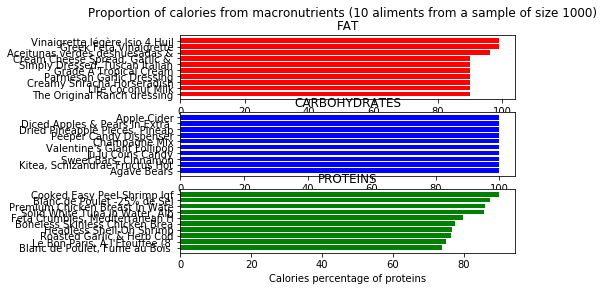

In [33]:
plot_nutrient_breakdown_ratio(df, macro_nutrients)

In [34]:
# 2 . repartition score

df = compute_repartition_score(df_food_study, col_macro_nutrients, df_reference_value)


In [35]:
# restricts to a sample of size 30 

df = df.iloc[0:30,]

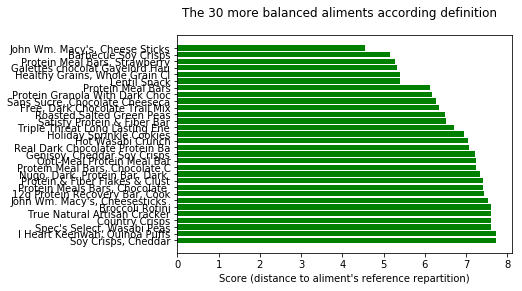

In [36]:
plot_nutrient_repartition_score(df)

ETUDE C :  Analyze ingredient's frequency
    
sub functions 

return a series of ingredients of randomly aliment retrieve from df_food_study

In [37]:
def get_aliment_ingredients(df_food_study):

    aliment = df_food_study.sample(1)
        
    ingredients = aliment.ingredients_text.str.replace(r'[-|_|(|)|.|,|*|%|#|:|\'\]\[]','')
    ingredients = ingredients.str.split()
    ingredients = ingredients.get_values()[0]
    ser_ingredients = pd.Series(ingredients)
    
    return (aliment, ser_ingredients)

retrieve a sample of aliments from df_food_study 
based on this sample, a dictionnary of ingredients with columns (ingredient_name, occurrences),
will be build 

în this dictionnary, ingredients will be sorted by 'occurences' and the shape will be limited to
ingredient_count

return a df containing a dictionnary of ingredients

In [38]:
def build_aliment_ingredient_dictionnary(df_food_study, sample_size:int, ingredient_count:int):

    dict_ingredients = {}
    f_build_ingredient_dictionary = utilities.build_word_dictionary(dict_ingredients)

    for i in np.arange(sample_size):
        ser_ingredients = get_aliment_ingredients(df_food_study)[1]
        f_build_ingredient_dictionary(ser_ingredients.to_json())

    df_dict = pd.DataFrame()
    df_dict = df_dict.from_dict(dict_ingredients, orient="index", columns=['occurences'])
    df_dict.sort_values('occurences', ascending=False, inplace=True)
    df_dict = df_dict.iloc[0:ingredient_count,]

    return df_dict

translate all entry of the df_dict index in a column called 'ingredient_en' and set
the index on this one

return a df with added columns 'ingredient_en'

In [39]:
def clean_word_dictionnary(df_dict):

    words_to_exclude = pd.Series(['A','THE','FROM', 'AND', 'OR','AND/OR', 'DE', 'ET', 'IN', 'OF', 
                                  'TO','AT', '&', 'PASTEURIZED', 'ENRICHED', 'MODIFIED',
                                  'CONTAINS', 'MALTED', 'LESS'])

    f_translate = utilities.translate_word()
    df_dict['ingredient_en'] = df_dict.index.to_series().apply(f_translate)

    df_dict.reset_index(inplace=True)
    df_dict.set_index('ingredient_en', inplace=True)
    df_dict.drop(words_to_exclude, errors="ignore", inplace=True)

    return df_dict    

ETUDE C : main functions

Analyze ingredient's frequency of ingredients used in aliments of df_food_study

In [40]:
def analyze_ingredients_frequency():

    df_food_study = helper_load_df_from_db("df_food_study_1", "df_food_study_2")
    df_food_study.set_index(['product_name'], inplace=True)

    aliment_sample_size = 1000
    ingredient_sample_size = 100
 
    df_dict = build_aliment_ingredient_dictionnary(df_food_study, 
                                                   aliment_sample_size, 
                                                   ingredient_sample_size)

    df_dict = clean_word_dictionnary(df_dict)
    df_dict.sort_values('occurences', ascending=False, inplace=True)
    
    df_dict = df_dict.iloc[0:30,] 
 
    fig, ax = plt.subplots()
    y_pos = np.arange(len(df_dict))
    ax.barh(y_pos, df_dict.occurences, align='center', color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_dict.index)
    ax.invert_yaxis() 
    ax.set_xlabel("Occurrences")
    ax.set_title("The 30 most common ingredients founded in " + 
                 str(aliment_sample_size) + " aliments")

    plt.show()

In [41]:
df_food_study = helper_load_df_from_db("df_food_study_1", "df_food_study_2")

In [42]:
df_food_study.columns

Index(['product_name', 'index', 'code', 'url', 'creator', 'created_t',
       'created_datetime', 'last_modified_t', 'last_modified_datetime',
       'brands', 'countries', 'countries_en', 'ingredients_text',
       'serving_size', 'additives_n', 'additives', 'additives_en',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g'],
      dtype='object')

In [43]:
    df_food_study.set_index(['product_name'], inplace=True)

    aliment_sample_size = 1000
    ingredient_sample_size = 100
 
    df_dict = build_aliment_ingredient_dictionnary(df_food_study, 
                                                   aliment_sample_size, 
                                                   ingredient_sample_size)

TypeError: from_dict() got an unexpected keyword argument 'columns'

In [ ]:
analyze_ingredients_frequency()

ETUDE E : DATABASE 

sub functions

prepare normalized data 

build a dictionnary of ingredients
for 1000 aliments randomly selected from df_food_study_2, extract its ingredients 
and join them with those in dictionnary

one table with aliment and one table with only product_name and ingredient_name
will be built

In [ ]:
def prepare_normalization():
    
    df_food_study = helper_load_df_from_db("df_food_study_1", "df_food_study_2")

    df_all_aliment = pd.DataFrame()
    df_all_aliment_ingredient = pd.DataFrame()

    df_global_dict = build_aliment_ingredient_dictionnary(df_food_study, 1000, 100)
    df_global_dict = clean_word_dictionnary(df_global_dict)

    dict_aliment_ingredient = {}
    f_build_ingredient_dictionary = utilities.build_word_dictionary(dict_aliment_ingredient)
    
    for i in np.arange(1000):
        (df_aliment, ser_ingredients) = get_aliment_ingredients(df_food_study)
        f_build_ingredient_dictionary(ser_ingredients.to_json())
        
        df_aliment_ingredient = pd.DataFrame().from_dict(dict_aliment_ingredient, orient="index", columns=['occurences'])
    
        i_ingredients_in_dict = df_aliment_ingredient.index.intersection(df_global_dict.index)
        i_ingredients_in_dict = i_ingredients_in_dict.drop_duplicates()

        df = pd.DataFrame(index=i_ingredients_in_dict, columns=['product_name'])
        df = df.fillna(str(df_aliment.product_name.values.item(0)))
        df = df.reset_index()
        df.columns = ['ingredient_name', 'product_name']
         
        df_all_aliment_ingredient = pd.concat([df_all_aliment_ingredient, df])
        df_all_aliment = pd.concat([df_all_aliment, df_aliment])

        dict_aliment_ingredient.clear()

    return (df_all_aliment, df_all_aliment_ingredient)


save normalized df to database df_food.db

In [ ]:
def build_normalized_database():

    (df_all_aliment, df_all_aliment_ingredient) = prepare_normalization()

    helper_store_df_to_db(df_all_aliment, 'df_food', 'aliment')
    helper_store_df_to_db(df_all_aliment_ingredient, 'df_food', 'aliment_ingredient')

    # set a primary key on table aliment
    
    db_file = PureWindowsPath(data_dir.joinpath('df_food.db'))
    db = sqlite3.connect(db_file.as_posix())
    c  = db.cursor()

    # SQLLITE doesn't support ALTER ADD / DROP 
    # c.execute("ALTER TABLE ALIMENT ADD PRIMARY KEY (product_name)")

    # retrieve ddl, modify it and replay

test database queries on df_food.db

query all aliments which contains SALT

In [ ]:
def perform_database_queries():

    build_normalized_database()

    db_file = PureWindowsPath(data_dir.joinpath('df_food.db'))
    db = sqlite3.connect(db_file.as_posix())

    # query all aliments which contains SALT
    df_q = pd.read_sql_query("select distinct(a.product_name) from aliment as a, aliment_ingredient as ai where ai.product_name = " +
                             " a.product_name and ai.ingredient_name = 'SALT'", con=db)

    return df_q

In [ ]:
perform_database_queries()

ETUDE F : CORRELATION 

sub fonctions

In [ ]:
def analyze_correlations(): 

    score_col = 'nutrition-score-fr_100g'
    cols_to_drop = set(['code', 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n'])
    cols_to_drop.add(score_col)
    
    df_food_study = helper_load_df_from_db("df_food_study_1", "df_food_study_2")

    # retains only float columns
    num_cols = utilities.select_columns(df_food_study, float)
    
    # eliminates all colums define above
    predictors_cols = set(num_cols).difference(cols_to_drop)

    # sample of size 1000 is significant enough
    df = df_food_study.sample(1000)
   
    df_corr = df.corr()
    df_corr = df_corr.sort_values(by=score_col, ascending = False)
    
    sns.pairplot(df_corr, 
                 x_vars=predictors_cols,
                 y_vars=[score_col], 
                 kind="reg",
                 plot_kws={'line_kws':{'color':'red'}})
    plt.show()

    return df_corr[score_col]